# SVM Evaluation

In [2]:
#from psd_functions import parse_benchmark,get_benchmarks, process_data, plot_data, plot_bars, plot_efficiency
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from time import time
from prince import PCA

import glob
import os
import plotly.express as px
import plotly.graph_objects as go

from scripts import *
import warnings
warnings.filterwarnings('ignore')


In [3]:
def plot_execution_time(df, parameter_name, mode = 'markers', logy = False):
    primal_time = df[df["type"]=="primal"]["solve_time"]
    dual_lin_time = df[df["type"]=="dual_linear"]["solve_time"]
    dual_ker_time = df[df["type"]=="dual_gaussian"]["solve_time"]
    parameter_values = df[df["type"]=="primal"][parameter_name]

    if logy:
        fig = px.scatter(y=primal_time, x=parameter_values, log_y=True)
    else:
        fig = px.scatter(y=primal_time, x=parameter_values)
    
    fig.add_trace(go.Scatter(x=parameter_values, y=primal_time,
                    mode=mode,
                    name='Primal'))
                    
    fig.add_trace(go.Scatter(x=parameter_values, y=dual_lin_time,
                    mode=mode,
                    name='Dual (linear)'))
    fig.add_trace(go.Scatter(x=parameter_values, y=dual_ker_time,
                    mode=mode,
                    name='Dual (kernel)'))
    #fig.update_layout(title=f"Solve time vs {parameter_name}")
    fig.update_xaxes(title_text=parameter_name)
    fig.update_yaxes(title_text="Solve time (s)")
    fig.update_traces(marker_size=10)
    fig.update_layout(legend_title_text="Nodes")
    fig.show()

def plot_execution_time_primal(df, parameter_name, mode = 'markers', logy = False):
    primal_time = df[df["type"]=="primal"]["solve_time"]
    parameter_values = df[df["type"]=="primal"][parameter_name]

    fig = px.scatter(y=primal_time, x=parameter_values)
    
    fig.add_trace(go.Scatter(x=parameter_values, y=primal_time,
                    mode=mode,
                    name='Primal'))
                    
    #fig.update_layout(title=f"Solve time vs {parameter_name}")
    fig.update_xaxes(title_text=parameter_name)
    fig.update_yaxes(title_text="Solve time (s)")
    fig.update_traces(marker_size=10)
    fig.update_layout(legend_title_text="Nodes")
    fig.show()

def plot_iterations(df, parameter_name, mode = 'markers', logy = False):
    primal_it = df[df["type"]=="primal"]["iterations"]
    dual_lin_it = df[df["type"]=="dual_linear"]["iterations"]
    dual_ker_it = df[df["type"]=="dual_gaussian"]["iterations"]
    parameter_values = df[df["type"]=="primal"][parameter_name]

    if logy:
        fig = px.scatter(y=primal_it, x=parameter_values, log_y=True)
    else:
        fig = px.scatter(y=primal_it, x=parameter_values)
    
    fig.add_trace(go.Scatter(x=parameter_values, y=primal_it,
                    mode=mode,
                    name='Primal'))
                    
    fig.add_trace(go.Scatter(x=parameter_values, y=dual_lin_it,
                    mode=mode,
                    name='Dual (linear)'))
    fig.add_trace(go.Scatter(x=parameter_values, y=dual_ker_it,
                    mode=mode,
                    name='Dual (kernel)'))
    #fig.update_layout(title=f"Solve time vs {parameter_name}")
    fig.update_xaxes(title_text=parameter_name)
    fig.update_yaxes(title_text="Iterations")
    fig.update_traces(marker_size=10)
    fig.update_layout(legend_title_text="Nodes")
    fig.show()
    
def plot_accuracy(df, parameter_name):
    primal_accuracy = df[df["type"]=="primal"]["accuracy"]
    dual_lin_accuract = df[df["type"]=="dual_linear"]["accuracy"]
    dual_ker_accuracy = df[df["type"]=="dual_gaussian"]["accuracy"]
    parameter_values = df[df["type"]=="primal"][parameter_name]

    fig = px.scatter(y=primal_accuracy, x=parameter_values)
    fig.add_trace(go.Scatter(x=parameter_values, y=primal_accuracy,
                    mode='lines+markers',
                    name='Primal'))
                    
    fig.add_trace(go.Scatter(x=parameter_values, y=dual_lin_accuract,
                    mode='lines+markers',
                    name='Dual (linear)'))
    fig.add_trace(go.Scatter(x=parameter_values, y=dual_ker_accuracy,
                    mode='lines+markers',
                    name='Dual (kernel)'))
    fig.update_layout(title=f"Accuracy vs {parameter_name}")
    fig.update_xaxes(title_text=parameter_name)
    fig.update_yaxes(title_text="Accuracy")
    fig.update_traces(marker_size=10)
    fig.update_layout(legend_title_text="Nodes")
    fig.show()


def time_heatmap(df, save=False,color = "accuracy", multiple = False, iris = False):
    # if color is solve_time use log scale
    if iris:
        fig = sns.heatmap(df.pivot("type", "nu", color), cbar=True,
                        annot=True, fmt=".2f", cmap="viridis")
        fig.set_xlabel("type")
        fig.set_ylabel("nu")
        fig.set_title(f"{color} heatmap for iris dataset")

        print(f"{color} heatmap")
        # legend execution time
        # set legend labels
        if save:
            fig.figure.savefig(f"plots/heatmap_iris_{color}.pdf", bbox_inches='tight')
        plt.show()
    else: 
        if not multiple:
            fig = sns.heatmap(df.pivot("m", "nu", color), cbar=True,
                            annot=True, fmt=".2f", cmap="viridis")
            fig.set_xlabel("m")
            fig.set_ylabel("nu")
        else:
            df_primal = df[df['type']=='primal']
            df_dual_lin = df[df['type']=='dual_linear']
            df_dual_ker = df[df['type']=='dual_gaussian']
            # three heatmaps side by side
            fig, axs = plt.subplots(1, 4, figsize=(16, 5),gridspec_kw=dict(width_ratios=[5,5,5,1]))
            # import lognorm
            from matplotlib.colors import LogNorm
            # get min and max values in the thre df
            min_val = min(df_primal[color].min(), df_dual_lin[color].min(), df_dual_ker[color].min())
            max_val = max(df_primal[color].max(), df_dual_lin[color].max(), df_dual_ker[color].max())
            sns.heatmap(df_primal.pivot("m", "nu", color),vmin=min_val, vmax=max_val,
                        annot=True, fmt=".2f",cbar=False,  cmap="viridis", ax=axs[0])
            sns.heatmap(df_dual_lin.pivot("m", "nu", color),vmin=min_val, vmax=max_val,
                        cbar=False, yticklabels=False,
                        annot=True, fmt=".2f", cmap="viridis", ax=axs[1])
            sns.heatmap(df_dual_ker.pivot("m", "nu", color), cbar=False,vmin=min_val, vmax=max_val,
                         yticklabels=False, 
                        annot=True, fmt=".2f", cmap="viridis", ax=axs[2])
            
            axs[0].set_title("Primal")
            axs[1].set_title("Dual (linear)")
            axs[2].set_title("Dual (kernel)")
            
        print(f"{color} heatmap")
        # legend execution time
        # set legend labels
        fig.colorbar(axs[1].collections[0], cax=axs[3])
        if save:
            fig.figure.savefig(f"plots/heatmap_{color}.pdf", bbox_inches='tight')
        plt.show()

In [4]:
# function that given a a model SMV_ampl and a vector of nu values, fits the models and returns the solve.time, accuracy and the value of the objective function
def fit_model(X_train, Y_train, X_test, Y_test, type, nu_values, n = 4):
    accuracies = []
    solve_times = []
    iterations = []
    for nu in nu_values:
        svm = SVM_ampl(type=type, nu=nu, solver='ipopt')
        svm = svm.fit(X_train, Y_train)
        y_pred = svm.predict(X_test)
        accuracies.append(np.sum(y_pred == Y_test)/len(Y_test))
        solve_times.append(svm.solve_time)
        iterations.append(svm.metrics['num_iterations'])
    return solve_times, accuracies, iterations

## Generated data

(The following cell takes about 80 minutes to run hence the results are saved in the 'df.pkl' file)

In [13]:
# fit the models for different sizes of m
m_values = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 666, 832, 1000] 
nu_values = [0.5, 1, 2, 5, 10]
types = ['primal', 'dual_linear', 'dual_gaussian']
    
# create a dataframe to store the results
df = pd.DataFrame(columns=['m', 'nu', 'type', 'accuracy', 'solve_time', 'obj_value'])

# for each size of m, fit the models and store the results in the dataframe
for m in m_values:
    data = SVM_data(m,0.2,seed=42)
    X_train, Y_train, X_test, Y_test = data.get_data()
    for type in types:
        solve_times, accuracies, iterations = fit_model(X_train, Y_train, X_test, Y_test, type, nu_values)
        for i in range(len(nu_values)):
            df = pd.concat([df, pd.DataFrame({'m': m, 'nu': nu_values[i], 'type': type, 'accuracy': accuracies[i], 'solve_time': solve_times[i], 'iterations': iterations[i]}, index=[0])], ignore_index=True)
df.to_pickle("dataset/df.pkl")

ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian k

accuracy heatmap


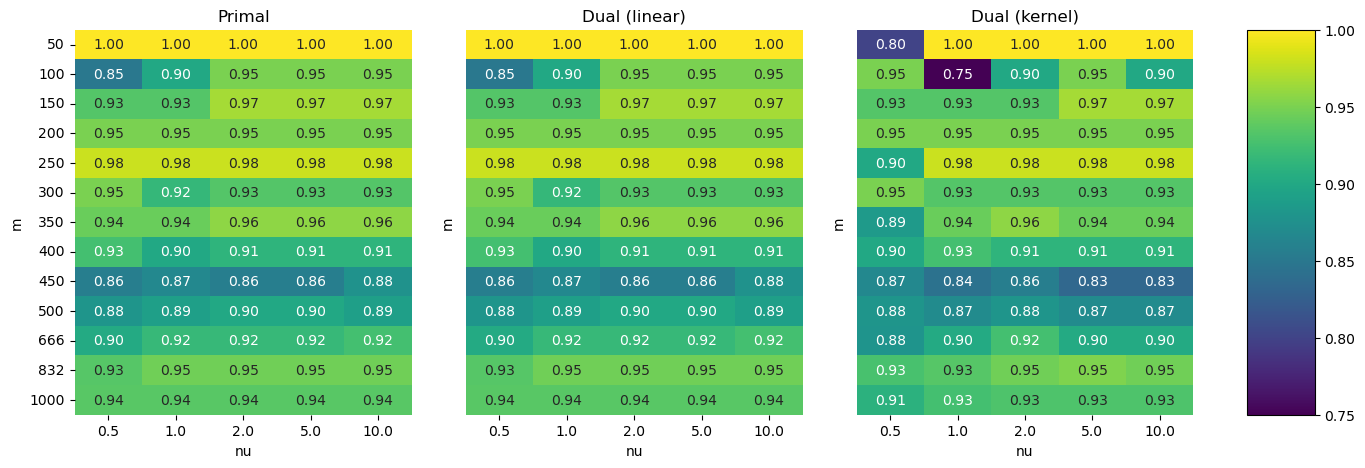

In [7]:
df = pd.read_pickle("dataset/df.pkl")
plot_execution_time(df, "m", logy=True)
plot_execution_time(df, "m", logy=False)
plot_iterations(df, "m", logy=False)
time_heatmap(df, save=True, multiple=True, iris=False)

We choose a concrete dataset with fixed nu

In [6]:
#generate the data
data = SVM_data(250,0.2,seed=42)
X_train, Y_train, X_test, Y_test = data.get_data()

# fit the models for different nu values
nu = 1
types = ['primal', 'dual_linear', 'dual_gaussian']

# create a dataframe to store the results
df_250 = pd.DataFrame(columns=['type', 'accuracy', 'gamma', 'w', 'iterations', 'solve time'])

#primal
primal = SVM_ampl(type='primal', nu=nu, solver='ipopt')
primal = primal.fit(X_train, Y_train)
y_pred = primal.predict(X_test)
accuracy = np.sum(y_pred == Y_test)/len(Y_test)
df_250 = pd.concat([df_250, pd.DataFrame({'type': 'primal', 'accuracy': accuracy, 'gamma': np.concatenate(primal.gamma), 'w': np.array2string(np.concatenate(primal.w), precision=4, separator=','), 'iterations': primal.metrics['num_iterations'], 'solve time': primal.solve_time}, index=[0])], ignore_index=True)

#dual_linear
dual_linear = SVM_ampl(type='dual_linear', nu=nu, solver='ipopt')
dual_linear = dual_linear.fit(X_train, Y_train)
y_pred = dual_linear.predict(X_test)
accuracy = np.sum(y_pred == Y_test)/len(Y_test)
df_250 = pd.concat([df_250, pd.DataFrame({'type': 'dual_linear', 'accuracy': accuracy, 'gamma': dual_linear.gamma, 'w': np.array2string(dual_linear.w, precision=4, separator=','), 'iterations': dual_linear.metrics['num_iterations'], 'solve time': dual_linear.solve_time}, index=[0])], ignore_index=True)

#sklearn SVC
sklearn = SVC(kernel='linear', C=1/nu)
start = time()
sklearn.fit(X_train, Y_train)
end = time()
y_pred = sklearn.predict(X_test)
accuracy = np.sum(y_pred == Y_test)/len(Y_test)
df_250 = pd.concat([df_250, pd.DataFrame({'type': 'sklearn SVC', 'accuracy': accuracy, 'gamma': sklearn.intercept_, 'w': np.array2string(np.concatenate(sklearn.coef_), precision=4, separator=','), 'iterations': sklearn.n_iter_, 'solve time': end-start}, index=[0])], ignore_index=True)

df_250

ipopt
ipopt
ipopt


,type,accuracy,gamma,w,iterations,solve time
0,primal,0.98,-6.046114,"[2.5755,3.0139,3.071 ,3.4197]",22,0.634856
1,dual_linear,0.98,-6.046115,"[2.5755,3.0139,3.071 ,3.4197]",15,2.302292
2,sklearn SVC,0.98,-6.044525,"[2.5746,3.0135,3.0705,3.4186]",241,0.006306


## Real dataset linearly separable

In [7]:
#read iris data
iris = pd.read_csv("dataset/iris.csv")
iris.iloc[:,-1] = np.where(iris.iloc[:,-1] == 'Iris-setosa', 1, -1)

X_train, X_test, Y_train, Y_test = train_test_split(iris.iloc[:,0:4], iris.iloc[:,-1], test_size=0.2, random_state=42)

X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy().astype(float)
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy().astype(float)

In [8]:
pca = PCA(n_components=2)
pca = pca.fit(pd.DataFrame(X_train))
X_train_pca = pca.transform(pd.DataFrame(X_train))

fig = px.scatter(x=X_train_pca[0], y=X_train_pca[1], color=Y_train)

fig.update_traces(marker=dict(size=12,
                                line=dict(width=2,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers'))
# remove colorbar
fig.update_layout(coloraxis_showscale=False)
# change axis title to Component 1 and Component 2
fig.update_layout(xaxis_title="Component 1", yaxis_title="Component 2")
# save to pca_iris.pdf

fig.show()

In [9]:
# fit the models for different nu values
nu = 1
types = ['primal', 'dual_linear', 'dual_gaussian']

# create a dataframe to store the results
df_iris = pd.DataFrame(columns=['type', 'accuracy', 'gamma', 'w', 'iterations', 'solve time'])

#primal
primal = SVM_ampl(type='primal', nu=nu, solver='ipopt')
primal = primal.fit(X_train, Y_train)
y_pred = primal.predict(X_test)
accuracy = np.sum(y_pred == Y_test)/len(Y_test)
df_iris = pd.concat([df_iris, pd.DataFrame({'type': 'primal', 'accuracy': accuracy, 'gamma': np.concatenate(primal.gamma), 'w': np.array2string(np.concatenate(primal.w), precision=4, separator=','), 'iterations': primal.metrics['num_iterations'], 'solve time': primal.solve_time}, index=[0])], ignore_index=True)

#dual_linear
dual_linear = SVM_ampl(type='dual_linear', nu=nu, solver='ipopt')
dual_linear = dual_linear.fit(X_train, Y_train)
y_pred = dual_linear.predict(X_test)
accuracy = np.sum(y_pred == Y_test)/len(Y_test)
df_iris = pd.concat([df_iris, pd.DataFrame({'type': 'dual_linear', 'accuracy': accuracy, 'gamma': dual_linear.gamma, 'w': np.array2string(dual_linear.w, precision=4, separator=','), 'iterations': dual_linear.metrics['num_iterations'], 'solve time': dual_linear.solve_time}, index=[0])], ignore_index=True)

#dual_gaussian
dual_gaussian = SVM_ampl(type='dual_gaussian', nu=nu, solver='ipopt')
dual_gaussian = dual_gaussian.fit(X_train, Y_train)
y_pred = dual_gaussian.predict(X_test)
accuracy = np.sum(y_pred == Y_test)/len(Y_test)
df_iris = pd.concat([df_iris, pd.DataFrame({'type': 'dual_gaussian', 'accuracy': accuracy, 'gamma': dual_gaussian.gamma, 'w': np.array2string(dual_gaussian.w, precision=4, separator=','), 'iterations': dual_gaussian.metrics['num_iterations'], 'solve time': dual_gaussian.solve_time}, index=[0])], ignore_index=True)

#sklearn SVC
sklearn = SVC(kernel='linear', C=1/nu)
start = time()
sklearn.fit(X_train, Y_train)
end = time()
y_pred = sklearn.predict(X_test)
accuracy = np.sum(y_pred == Y_test)/len(Y_test)
df_iris = pd.concat([df_iris, pd.DataFrame({'type': 'sklearn SVC', 'accuracy': accuracy, 'gamma': sklearn.intercept_, 'w': np.array2string(np.concatenate(sklearn.coef_), precision=4, separator=','), 'iterations': sklearn.n_iter_, 'solve time': end-start}, index=[0])], ignore_index=True)

df_iris

ipopt
ipopt
ipopt
ipopt
predicting with gaussian kernel


,type,accuracy,gamma,w,iterations,solve time
0,primal,1.0,1.450561,"[-0.046 , 0.5217,-1.0032,-0.4642]",26,0.698500
1,dual_linear,1.0,1.450587,"[-0.046 , 0.5217,-1.0032,-0.4642]",15,1.005960
2,dual_gaussian,1.0,-0.265180,"[0.,0.,0.,0.]",14,1.468409
3,sklearn SVC,1.0,1.447464,"[-0.0458, 0.5222,-1.0029,-0.4641]",6,0.002467
